# Superpixel learning


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian
import torch.nn.functional as F


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = set_device(verbose=True)

Using backend: pytorch


cuda available


# MNIST Superpixel 

In [2]:
from molecules import MoleculeDatasetDGL, MoleculeDataset

dataset = MoleculeDataset('ZINC') 
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 7.3210s


## Visualise the dataset

Label: tensor([1.9810])
graph: DGLGraph(num_nodes=27, num_edges=58,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
Largest eigenvalue: 1.9952804001632463
Smallest eigenvalue: -2.5673907444456745e-16


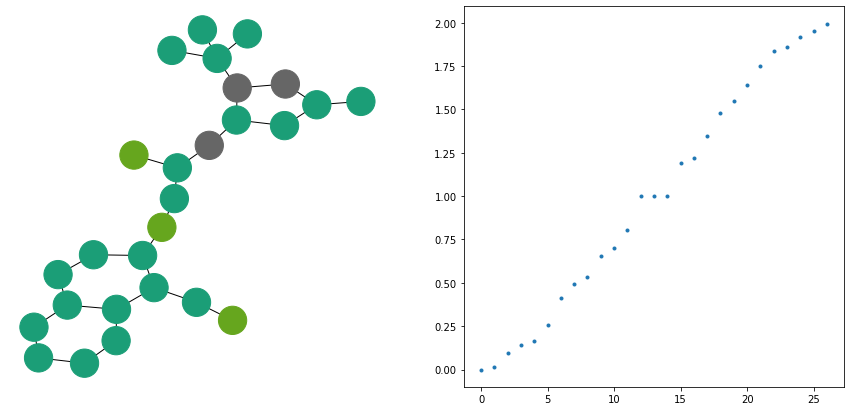

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(50)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),
                     node_color=g_demo.ndata['feat'],
                     node_size=800,
                     cmap='Dark2')

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

# Model definition for training

In [4]:
from model_ZINC import Cheb_ZINC
# model_parameters
in_features = 1
conv_out = 128
hidden_layer_classifier = 128
k = 2
n_classes = 1

net = Cheb_ZINC(
    dataset.num_atom_type, 
    conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Cheb_ZINC(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (fc): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): Cheb_Conv(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): Cheb_Conv(
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (embedding_h): Embedding(28, 128)
)


In [5]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_superpix_overfit'))

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)

loss_func = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

epoch_losses = []

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        epoch_train_mae = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            bGraph, label = bGraph.to(device), label.to(device)
            
            
            output = model(bGraph, 
                           bGraph.ndata.pop('feat').view(-1,1).to(device))
            
            loss = loss_func(output, label.view_as(output).to(device))
            epoch_train_mae += F.l1_loss(output,  label.view_as(output))
            

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # put a max - min error?
        
        epoch_loss /= iter + 1
        epoch_train_mae /= (iter + 1)
        #print('MAE', epoch_train_mae)
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - of : {} data in {:.1f}s".format(
                epoch, epoch_loss, val_loss, len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_loss = 0
    tot_pred = []
    epoch_test_mae = 0
    
    #MAE = F.l1_loss

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].view(-1,1).float())
            # sum up batch loss
            test_loss += loss_func(output, label.view_as(output).to(device)).item()
            epoch_test_mae += F.l1_loss(output,  label.view_as(output) )
            tot_loss += test_loss
            
    test_loss /= iter + 1
    epoch_test_mae /= (iter + 1)

    if verbose:
        print('\n Average loss per epoch: {:.4f}, total loss: {:.4f} of {} molecules \n'.format(
            test_loss,tot_loss, len(test_loader.dataset)))
        print('MAE :', epoch_test_mae)

    else:
        return test_loss#, tot_loss

## Training time

In [16]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Epoch 0 loss - train 0.4481 - val 0.4635 - of : 10000 data in 95.5s
Epoch 1 loss - train 0.4513 - val 0.5095 - of : 10000 data in 94.9s
Epoch 2 loss - train 0.4476 - val 0.4835 - of : 10000 data in 98.4s
Epoch 3 loss - train 0.4481 - val 0.5118 - of : 10000 data in 98.7s
Epoch 4 loss - train 0.4372 - val 0.4664 - of : 10000 data in 94.9s
Epoch 5 loss - train 0.4327 - val 0.4542 - of : 10000 data in 95.4s
Epoch 6 loss - train 0.4321 - val 0.4719 - of : 10000 data in 95.3s
Epoch 7 loss - train 0.4207 - val 0.4851 - of : 10000 data in 94.1s
Epoch 8 loss - train 0.4178 - val 0.4642 - of : 10000 data in 94.0s
Epoch 9 loss - train 0.4168 - val 0.4474 - of : 10000 data in 94.2s
Epoch 10 loss - train 0.4212 - val 0.4468 - of : 10000 data in 93.8s
Epoch 11 loss - train 0.4034 - val 0.4471 - of : 10000 data in 94.2s
Epoch 12 loss - train 0.4013 - val 0.4390 - of : 10000 data in 94.1s
Epoch 13 loss - train 0.4019 - val 0.4467 - of : 10000 data in 93.7s
Epoch 14 loss - train 0.4072 - val 0.4463 - 

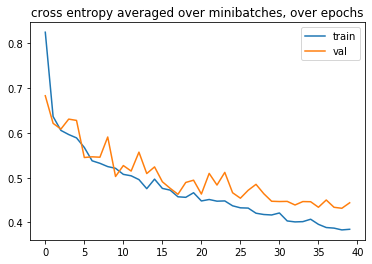

In [17]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [18]:
torch.cuda.empty_cache()

## Test Metrics

In [19]:
test(net,device,test_loader)
torch.cuda.empty_cache()

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)



 Average loss per epoch: 0.4551, total loss: 1.3396 of 1000 molecules 

MAE : tensor(0.4551, device='cuda:0')


In [20]:
def preds_f(model, device, data_loader, verbose=True):
    model.eval()

    output = torch.Tensor([]).to(device)

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = torch.cat((output,model(Bgraph, Bgraph.ndata['feat'].view(-1,1).float())),0)

        return output

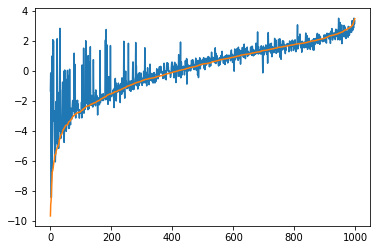

In [21]:
import numpy as np
preds = preds_f(net,device,test_loader).cpu()
plt.plot([x for _,x in sorted(zip(testset.graph_labels,preds))])
plt.plot(sorted(testset.graph_labels))

## Saving

In [22]:
from utils import save_model

save_model("Zinc_mean", net)